#  AWS Machine Learning Engineer Nanodegree Scholarship – Udacity 
# Optimizing Starbucks rewards using Machine Learning 
## [Capstone Project]

### Model Building and Deployment


In [1]:
!pip install sagemaker
!pip install xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

### Import Important libraries

In [2]:

# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# import sklearn libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# import sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri


In [3]:
import json
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, cohen_kappa_score, roc_curve, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer, CSVSerializer
from sagemaker.deserializers import JSONDeserializer

from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker import image_uris
from sagemaker.amazon.amazon_estimator import image_uris

#### We will use the CSV file that contain our Cleaned Dataset 

In [4]:
df = pd.read_csv('Data_cleaned.csv')
df = df.drop(columns='Unnamed: 0')

##### Peek into the Cleaned Dataset DataFrame Table

In [5]:
df.head(5)

offerid                        customerid  time  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  78afa995795e4d85b5d9ceeca43f5fef   0.0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0  ff7cb44e72db4112b270560686f97a23   0.0   
2  5a8bc65990b245e5a138643cd4eb9837  97b6993c232946d3b6b9f90530ff8073   0.0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  81848348d5584aef9e7374a07ebe6ea1   0.0   
4  fafdcd668e3743c1bb461111dcafc2a4  28f9666945804ab0bfc63f3ec6ae9af1   0.0   

   offersuccessful  totalamount  duration  reward  bogo  discount  \
0                1        37.67         7       5     1         0   
1                1        48.31         5      10     1         0   
2                0        23.43         3       0     0         0   
3                0        52.24         7       5     1         0   
4                0         5.12        10       2     0         1   

   informational  ...  social  web  gender    income  2013  2014  2015  2016  \
0              0  ...       0    1       0  100000.0     0     0     0     0   
1              0  ...       1    1       0   39000.0     0     0     1     0   
2              1  ...       1    0       1   52000.0     0     0     0     0   
3              0  ...       0    1       0  118000.0     0     0     0     1   
4              0  ...       1    1       0   44000.0     0     0     0     0   

   2017  2018  
0     1     0  
1     0     0  
2     1     0  
3     0     0  
4     0     1  

[5 rows x 22 columns]

##### We will Drop those columns 

In [6]:
df = df.drop(columns=['time','customerid','email','informational'])

#### Cleaned Dataset final Columns

In [7]:
df.columns

Index(['offerid', 'offersuccessful', 'totalamount', 'duration', 'reward',
       'bogo', 'discount', 'mobile', 'social', 'web', 'gender', 'income',
       '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

### Normalizing the Data using min max scaler
* Min-max normalization is one of the most common ways to normalize data.
* For every feature, the minimum value of that feature gets transformed into a 0.
* And the maximum value gets transformed into a 1, and every other value gets transformed into a decimal between 0 and 1.
##### Normalized Columns:
      - income 
      - totalamount
      - duration
      - reward

In [8]:
scaler = preprocessing.MinMaxScaler()

min_max_scaler = preprocessing.MinMaxScaler()

cols_to_scale = ['income','totalamount','duration','reward']
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [9]:
df = scaleColumns(df, cols_to_scale)
df = df.drop(['offerid'], axis=1)
df.head(5)

offersuccessful  totalamount  duration  reward  bogo  discount  mobile  \
0                1     0.031366  0.571429     0.5     1         0       1   
1                1     0.040225  0.285714     1.0     1         0       1   
2                0     0.019509  0.000000     0.0     0         0       1   
3                0     0.043497  0.571429     0.5     1         0       1   
4                0     0.004263  1.000000     0.2     0         1       1   

   social  web  gender    income  2013  2014  2015  2016  2017  2018  
0       0    1       0  0.777778     0     0     0     0     1     0  
1       1    1       0  0.100000     0     0     1     0     0     0  
2       1    0       1  0.244444     0     0     0     0     1     0  
3       0    1       0  0.977778     0     0     0     1     0     0  
4       1    1       0  0.155556     0     0     0     0     0     1

##### ``value_counts()`` function returns an object containing counts of unique values and in our case it will return counts of successful offers

In [10]:
df.offersuccessful.value_counts()

0    34729
1    30856
Name: offersuccessful, dtype: int64

### Splitting The Dataset into Train and Test set For Further Using in the Algorithms 

In [11]:
y = df.filter(['offersuccessful'])
X = df.drop('offersuccessful', axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Checking The Size of Training and Test Set 

In [13]:
trainX_size = np.round(X_train.shape[0] / df.shape[0], 2)
testX_size = np.round(X_test.shape[0] / df.shape[0], 2)
trainY_size = np.round(y_train.shape[0] / df.shape[0], 2)
testY_size = np.round(y_test.shape[0] / df.shape[0], 2)

print(f"Train X Size: {trainX_size}")
print(f"Test X Size: {testX_size}")
print(f"Train Y Size: {trainY_size}")
print(f"Test Y Size: {testY_size}")

Train X Size: 0.67
Test X Size: 0.33
Train Y Size: 0.67
Test Y Size: 0.33


### KNeighborsClassifier 
- The K in the name of this classifier represents the k nearest neighbors.
- k is an integer value.
- this classifier implements learning based on the k nearest neighbors.


In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=6,algorithm='kd_tree')

knn_model.fit(X_train, y_train)


y_preds_knn=knn_model.predict(X_test)


#### Evaluation Metric [KNeighborsClassifier]

In [15]:
data_knn = [['F1', f1_score(y_test, y_preds_knn)], 
           ['Precision', precision_score(y_test, y_preds_knn)],
           ['Recall', recall_score(y_test, y_preds_knn)],
           ['ROC-AUC', roc_auc_score(y_test, y_preds_knn)]]  
  

#### Create DataFrame for Evluation Metric [KNeighborsClassifier]

In [16]:
results_knn = pd.DataFrame(data_knn, columns = ['Measure', ' k-nearest neighbors']) 
results_knn

Measure   k-nearest neighbors
0         F1              0.840649
1  Precision              0.894211
2     Recall              0.793140
3    ROC-AUC              0.854263

### eXtreme Gradient Boosting [XGBoostClassifier]

In [17]:
# create the object
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', learning_rate=0.01,random_state=42)

# train
xgb_model.fit(X_train, y_train)

# predict
y_preds_xg = xgb_model.predict(X_test)

#### Evaluation Metric [XGBClassifier]

In [18]:
data_xg = [['F1', f1_score(y_test, y_preds_xg)], 
           ['Precision', precision_score(y_test, y_preds_xg)],
           ['Recall', recall_score(y_test, y_preds_xg)],
           ['ROC-AUC', roc_auc_score(y_test, y_preds_xg)]]  
  


#### Create DataFrame for Evaluation Metric [XGBClassifier]

In [19]:
results_xg = pd.DataFrame(data_xg, columns = ['Measure', 'XGBoost'])

##### Merging Both Evaluation Metric for [KNeighborsClassifier] and [XGBClassifier]

In [20]:
results1 = results_knn.merge(results_xg, left_on='Measure', right_on='Measure')
results1

Measure   k-nearest neighbors   XGBoost
0         F1              0.840649  0.913072
1  Precision              0.894211  0.887143
2     Recall              0.793140  0.940563
3    ROC-AUC              0.854263  0.916332

## **Amazon SageMaker !**

### SageMaker XGBoost
- With SageMaker, we can use XGBoost as a built-in algorithm. 
- Using XGBoost as a built-in algorithm to run training scripts in your local environments. 
- This is has a smaller memory footprint, better logging, improved hyperparameter validation, and an expanded set of metrics than the original versions. 
- It also provides an XGBoost estimator that executes a training script in a managed XGBoost environment. 

### Basic definitions that help us get permission to execute training jobs and to interact with other AWS services as S3 Bucket to retrieve and upload data.
#### - The S3 bucket and prefix that we want to use for training and model data. 
#### - This should be within the same region as the Notebook Instance, training, and hosting.
#### - The IAM role arn used to give training and hosting access to your data. 

In [21]:
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.boto_region_name

#### - We will Use the Default Bucket 

In [22]:
bucket = session.default_bucket()

#### - Creating Directory to save the Features Data For further Use.
#### - Setting prefix, a descriptive name for a directory.

In [23]:
data_dir = 'starbucks_data'
 
prefix = 'starbucks'

#### - Uploading all Data to S3 Bucket

In [24]:
input_data = session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

#### - First we need to check and make sure that the local directory in that we will store the training and validation csv files exists.

In [25]:
import os
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)


#### - We will Create validation set from the training set.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

#### - Splitting the Data into training, validation, and test sets. 
#### - This will help prevent us from over-fitting the model.
#### - And allow us to test the model’s accuracy on data it hasn’t already seen.
#### - XGBoost algorithm in SageMaker requires that the training and validation datasets should contain no headers or index and that the label should occur first for each sample.

In [27]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

#### - Uploading the Data into the S3 Bucket

In [28]:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)

#### - Confirming and Checking that the Data is in S3 Bucket

In [29]:
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

starbucks/test.csv
starbucks/train.csv
starbucks/validation.csv
Test passed!


#### - Using the XGBoost built-in algorithm to build an XGBoost training container 
#### - We can automatically spot the XGBoost built-in algorithm image URI using the SageMaker ``image_uris.retrieve``

In [30]:
container = image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='1.0-1')

#### - This notebook was created and tested on a ``ml.m4.xlarge`` notebook instance.

#### - After specifying the XGBoost image URI
#### - We can use the XGBoost container to construct an estimator using the SageMaker Estimator and initiate a training job. 

#### - we can specify a few parameters 
- type of training instances `` instance_type`` 
- And how many instances ``instance_count``

In [31]:
#construct a SageMaker estimator that calls the xgboost-container
xgb = sagemaker.estimator.Estimator(container, # location of the container 
                                    role,                                    
                                    instance_count=1,                 
                                    instance_type='ml.m4.xlarge',     
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)


### XGBoost Hyperparameters
- ``max_depth`` controls how deep each tree within the algorithm can be built. 
    - Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting. 
    - There is typically some trade-off in model performance that needs to be explored between numerous shallow trees an      a smaller number of deeper trees.
- ``subsample`` controls sampling of the training data. 
   - This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- ``num_round`` controls the number of boosting rounds. 
   - This is essentially the subsequent models that are trained using the residuals of previous iterations. 
   - Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to over-fitting. 
- ``eta`` controls how aggressive each round of boosting is. 
   - Larger values lead to more conservative boosting. - gamma controls how aggressively trees are grown. Larger values lead to more conservative models.
- ``tweedie_variance_power`` Parameter that controls the variance of the Tweedie distribution.
- ``rate_drop`` Dropout rate (a fraction of previous trees to drop during the dropout).
- ``min_child_weight`` Minimum sum of instance weight (hessian) needed in a child. 
- ``eval_metric`` function to optimize during model training.
   - ``auc: Area`` under the curveEvaluation metrics for validation data, a default metric will be assigned according to objective.
   - Optimization Direction: Maximize.
- Learning ``objective`` function to optimize during model training.
   - ``binary:logistic`` logistic regression for binary classification, output probability.

In [32]:
# Set the algorithm specific parameters.
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric="auc",
                        rate_drop=0.3,
                        tweedie_variance_power=1.4,
                        early_stopping_rounds=20,
                        num_round=600)

#### - Because we’re training with the CSV file format
#### - we’ll create TrainingInputs that our training function can use as a pointer to the files in S3.

In [33]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='text/csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='text/csv')

### Now it is time to train!
#### - Train the XGBoost Model
#### - To do this we specify our S3 bucket's location that is storing our training data and validation data and pass it via a dictionary to the fit method.

In [34]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2022-02-23 05:02:39 Starting - Starting the training job...
2022-02-23 05:03:02 Starting - Launching requested ML instancesProfilerReport-1645592559: InProgress
.........
2022-02-23 05:04:23 Starting - Preparing the instances for training......
2022-02-23 05:05:23 Downloading - Downloading input data...
2022-02-23 05:06:04 Training - Downloading the training image...
2022-02-23 05:06:36 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter o

## ***Amazon SageMaker Random Search and Hyperparameter Scaling with SageMaker XGBoost and Automatic Model Tuning.*** 

#### *This part showcases the use of two **Hyperparameter Tuning features**:* 
- *Random Search.*
- *Hyperparameter Scaling.*

### ***Random search***
- *Using **Random Search** to tell Amazon SageMaker to choose hyperparameter configurations from a random distribution.*

- *The main advantage of random search is that all jobs can be run in parallel.* 
- *Using **Random Search** with **Automatic Model Tuning** allows us achieve faster results .*


### ***Hyperparameter scaling***
- *Hyperparameters whose value can meaningfully span multiple orders of magnitude.* 
- *If I we manually tried a few different step sizes for a deep learning algorithm to explore the effect of varying this hyperparameter, we would likely choose powers of 10 (such as 1.0, 0.1, 0.01, …) rather than equidistant values (such as 0.1, 0.2, 0.3, …).* 
- *As know from experience that the latter is unlikely to change the behavior of the algorithm much.* 
- *For many hyperparameters, changing the order of magnitude yields much more interesting variation.*



## ***NOW WE START !***

### ***Logarithmic Scaling***
- Both cases we use logarithmic scaling.
- Which is the scaling type that should be used whenever the order of magnitude is more important that the absolute value.
- Used if a change, say, from 1 to 2 is expected to have a much bigger impact than a change from 100 to 101.
- Due to the fact that the hyperparameter doubles in the first case but not in the latter.

*We set a **hyperparameter scaling** type to **Logarithmic**.*

In [35]:
hyperparameter_ranges = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
}

#### ***Random search***
- ***We now start a tuning job using random search!***
- ***The main advantage of using random search is that this allows us to train jobs with a high level of parallelismm***

In [36]:
objective_metric_name = "validation:auc"
tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

tuner_log.fit({"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False)

...................................................................!


#### ***Run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.***

In [37]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

##### ***Comparing the results with executing a job using linear scaling.***

#### ***Linear Scaling*** 
-  SageMaker assumes a uniform distribution of hyperparameter values and uses linear scaling to select values in a search range. 

In [38]:
hyperparameter_ranges_linear = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Linear"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Linear"),
}

In [39]:
tuner_linear = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

tuner_linear.fit({"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False,)

..........................................................!


#### ***Checking of the hyperparameter tuning jobs status***

In [40]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

#### ***Analyze Tuning Job Results - After Tuning Job is Completed***
- ***Once the tuning jobs have completed!***
- ***We can compare the distribution of the hyperparameter configurations chosen in the two cases***

In [41]:

# check jobs have finished
status_log = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]
status_linear = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

assert status_log == "Completed", "First must be completed, was {}".format(status_log)
assert status_linear == "Completed", "Second must be completed, was {}".format(status_linear)

df_log = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_log.latest_tuning_job.job_name
).dataframe()
df_linear = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_linear.latest_tuning_job.job_name
).dataframe()
df_log["scaling"] = "log"
df_linear["scaling"] = "linear"
df = pd.concat([df_log, df_linear], ignore_index=True)

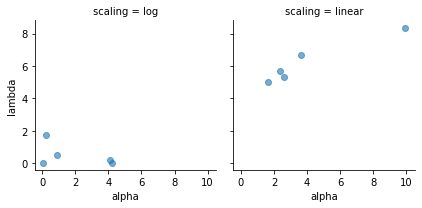

In [42]:
g = sns.FacetGrid(df, col="scaling", palette="viridis")
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.6)

### ***Deploy the XGBoost Model*** 

In [43]:
xgb_predictor = tuner_linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


2022-02-23 05:17:38 Starting - Preparing the instances for training
2022-02-23 05:17:38 Downloading - Downloading input data
2022-02-23 05:17:38 Training - Training image download completed. Training in progress.
2022-02-23 05:17:38 Uploading - Uploading generated training model
2022-02-23 05:17:38 Completed - Training job completed
----------!

#### ***Serializing Data for an inference endpoint.***
#### ***We need to tell the endpoint what format the data we are sending is in so that SageMaker can perform the serialization.***
#### ***Serialize data of various formats to a CSV-formatted string.***

In [44]:
from sagemaker.predictor import csv_serializer

xgb_predictor.__setattr__(xgb_predictor.content_type, "text/csv")
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

#### ***We split the data into chunks and send each chunk seperately, accumulating the results.***


In [45]:
def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    
    return np.fromstring(predictions[1:], sep=',')

test_X = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None).values

predictions = predict(test_X)
predictions = [round(num) for num in predictions]

#### ***Evaluation Metric [Model Tuning XGBClassifier]***

In [46]:
aws_xg1 = [['F1', f1_score(y_test, predictions)], 
           ['Precision', precision_score(y_test, predictions)],
           ['Recall', recall_score(y_test, predictions)],
           ['ROC-AUC', roc_auc_score(y_test, predictions)]] 

# Create the pandas DataFrame  
aws_results_xg1 = pd.DataFrame(aws_xg1, columns = ['Measure', 'XGBoost'])    

In [47]:
aws_results_xg1


Measure   XGBoost
0         F1  0.913781
1  Precision  0.896271
2     Recall  0.931989
3    ROC-AUC  0.917361

#### ***Merging All Evaluation Metrics for [KNeighborsClassifier] and [XGBClassifier] with [Model Tuning XGBClassifier].***

In [48]:
resultsz = results1.merge(aws_results_xg1, left_on='Measure', right_on='Measure')
resultsz

Measure   k-nearest neighbors  XGBoost_x  XGBoost_y
0         F1              0.840649   0.913072   0.913781
1  Precision              0.894211   0.887143   0.896271
2     Recall              0.793140   0.940563   0.931989
3    ROC-AUC              0.854263   0.916332   0.917361

## ***Finally ! Clearing our AWS Resources*** 
### ***Deleting Endpoints and Created Buckets For not causing any Additional Costs***

In [49]:
xgb_predictor.delete_endpoint()

#### ***Deleting Created Buckt that we used !***

In [50]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '3E0C403TADDDQ85H',
   'HostId': '45RwFEmAhpF9xRs7Jtsnsyu5Wn3j6iNWCqI5nCZcHfPealQfs0uL9npd+Q1/HzJwarmxdSfCAvY=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': '45RwFEmAhpF9xRs7Jtsnsyu5Wn3j6iNWCqI5nCZcHfPealQfs0uL9npd+Q1/HzJwarmxdSfCAvY=',
    'x-amz-request-id': '3E0C403TADDDQ85H',
    'date': 'Wed, 23 Feb 2022 05:23:04 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'starbucks/output/sagemaker-xgboost-2022-02-23-05-02-39-024/rule-output/ProfilerReport-1645592559/profiler-output/profiler-reports/MaxInitializationTime.json'},
   {'Key': 'starbucks/output/sagemaker-xgboost-2022-02-23-05-02-39-024/output/model.tar.gz'},
   {'Key': 'starbucks/output/sagemaker-xgboost-220223-0507-005-fd8ce165/output/model.tar.gz'},
   {'Key': 'starbucks/output/sagemaker-xgboost-220223-0513-003-25300d7b/output/model.tar.gz'},
   